# Implementing Logistic Regression

In [26]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Source Code
The complete logistic regression implementation can be found in my [Github repository]().

## Abstract

In this blog post, I implement logistic regression with gradient descent optimization using PyTorch. I explore the benefits of gradient descent with momentum compared to vanilla gradient descent, demonstrating how momentum accelerates convergence by accumulating velocity in consistent gradient directions. Through four experiments, I investigate:

1. the convergence properties of vanilla gradient descent
2. the acceleration benefits of momentum
3. the overfitting phenomenon in high-dimensional spaces
4. the practical application of both optimization methods on the Breast Cancer Wisconsin dataset.

The results clearly demonstrate that gradient descent with momentum converges faster and achieves better final performance than vanilla gradient descent.

## Experiments

Here are the helping methods:

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

def plot_decision_boundary(X, y, model, ax=None, title=None):
    if ax is None:
        ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points
    ax.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color='blue', label='Class 0', alpha=0.5)
    ax.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color='red', label='Class 1', alpha=0.5)
    
    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Create features for grid points (add constant 1)
    grid = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    
    # Get predictions
    Z = model.predict(grid_tensor).detach().numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contour(xx, yy, Z, levels=[0.5], colors='black')
    
    # Add labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    if title:
        ax.set_title(title)
    ax.legend()
    
    return ax


### Experiment 1: Vanilla gradient descent

This experiment aims to demonstrate the fundamental behavior of vanilla gradient descent for logistic regression on a simple binary classification problem. The goal is to show that when the learning rate (α) is properly chosen and the dataset is relatively simple, gradient descent will converge smoothly to a solution that effectively separates the two classes.

/var/folders/9f/x536p69s5px424c7twrmgtp40000gn/T/ipykernel_78698/2787871557.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
/var/folders/9f/x536p69s5px424c7twrmgtp40000gn/T/ipykernel_78698/2787871557.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.01))


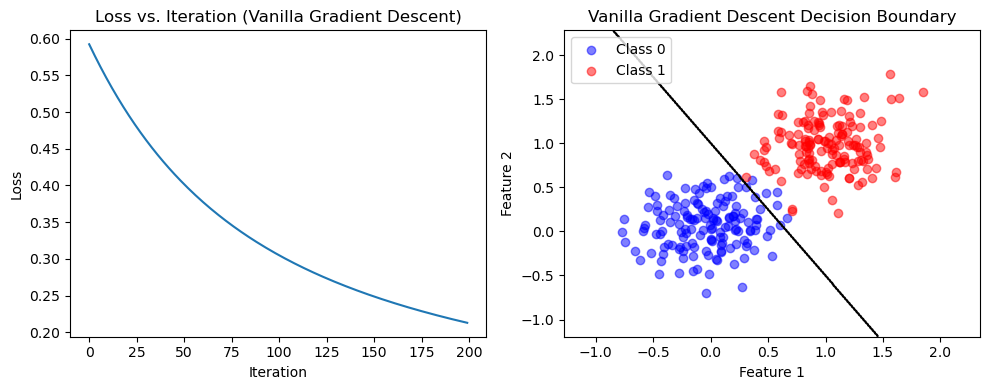

In [28]:
# Generate data
X, y = classification_data(n_points=300, noise=0.3)

# Initialize model and optimizer
lr = LogisticRegression()
opt = GradientDescentOptimizer(lr)

# Training loop
losses = []
n_iterations = 200

for i in range(n_iterations):
    loss = lr.loss(X, y)
    losses.append(loss.item())
    
    opt.step(X, y, alpha=0.1, beta=0)

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration (Vanilla Gradient Descent)')

# Plot decision boundary
ax = plt.subplot(1, 2, 2)
plot_decision_boundary(X, y, lr, ax, title='Vanilla Gradient Descent Decision Boundary')

plt.tight_layout()
plt.show()


Figure 1 demonstrates that vanilla gradient descent successfully converges on the classification task. The left plot shows the loss decreasing monotonically over 200 iterations, starting at around 0.55 and dropping to about 0.20. The right plot displays the decision boundary as a clean linear separator between the two classes (blue and red), showing that the model effectively learned to distinguish between them.

### Experiment 2: Benefits of momentum

This experiment compares vanilla gradient descent with gradient descent using momentum to highlight the acceleration benefits that momentum provides during optimization. Momentum works by accumulating a velocity vector in directions of consistent gradient, which helps overcome plateaus in the loss landscape and dampens oscillations in directions with high curvature.

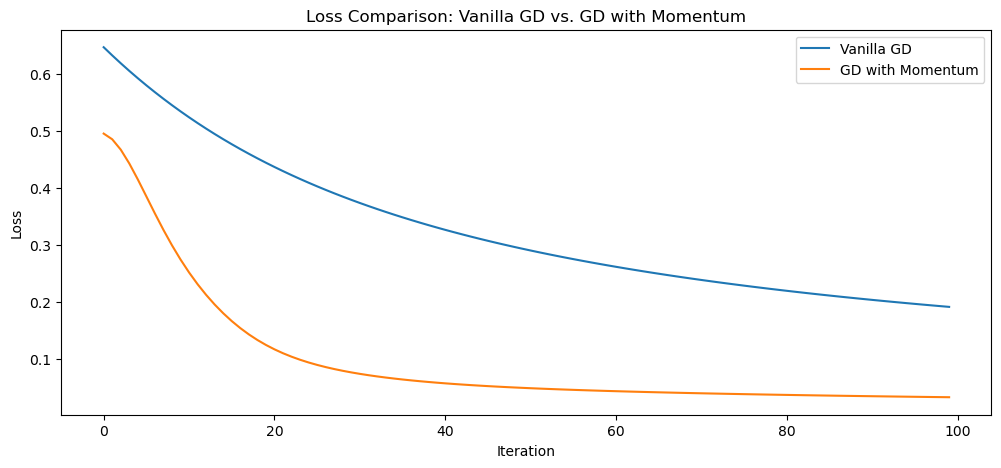

In [29]:
X, y = classification_data(n_points=300, noise=0.3)

# Initialize models and optimizers
lr_vanilla = LogisticRegression()
opt_vanilla = GradientDescentOptimizer(lr_vanilla)

lr_momentum = LogisticRegression()
opt_momentum = GradientDescentOptimizer(lr_momentum)

# Training loop for vanilla GD
losses_vanilla = []

# Training loop for GD with momentum
losses_momentum = []

n_iterations = 100

for i in range(n_iterations):
    # Vanilla GD
    loss_vanilla = lr_vanilla.loss(X, y)
    losses_vanilla.append(loss_vanilla.item())
    opt_vanilla.step(X, y, alpha=0.2, beta=0)
    
    # GD with momentum
    loss_momentum = lr_momentum.loss(X, y)
    losses_momentum.append(loss_momentum.item())
    opt_momentum.step(X, y, alpha=0.2, beta=0.9)

# Plot comparison of losses
plt.figure(figsize=(12, 5))

plt.plot(losses_vanilla, label='Vanilla GD')
plt.plot(losses_momentum, label='GD with Momentum')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Comparison: Vanilla GD vs. GD with Momentum')
plt.legend()
plt.show()

Figure 2 compares vanilla gradient descent with gradient descent using momentum. The momentum-based approach (orange line) converges much faster than vanilla GD (blue line). While both methods start at similar loss values (0.55-0.60), the momentum approach reaches a loss of 0.1 in just 20 iterations, whereas vanilla GD requires about 80 iterations to reach 0.2. By the end of training, momentum achieves a significantly lower final loss (~0.02 vs ~0.17).

### Experiment 3: Overfitting

This experiment explores the fundamental problem of overfitting in machine learning, which occurs when a model learns the training data too well, including its noise and peculiarities, at the expense of generalization to new data. We deliberately create a challenging scenario with 100 features but only 50 data points to demonstrate this phenomenon.

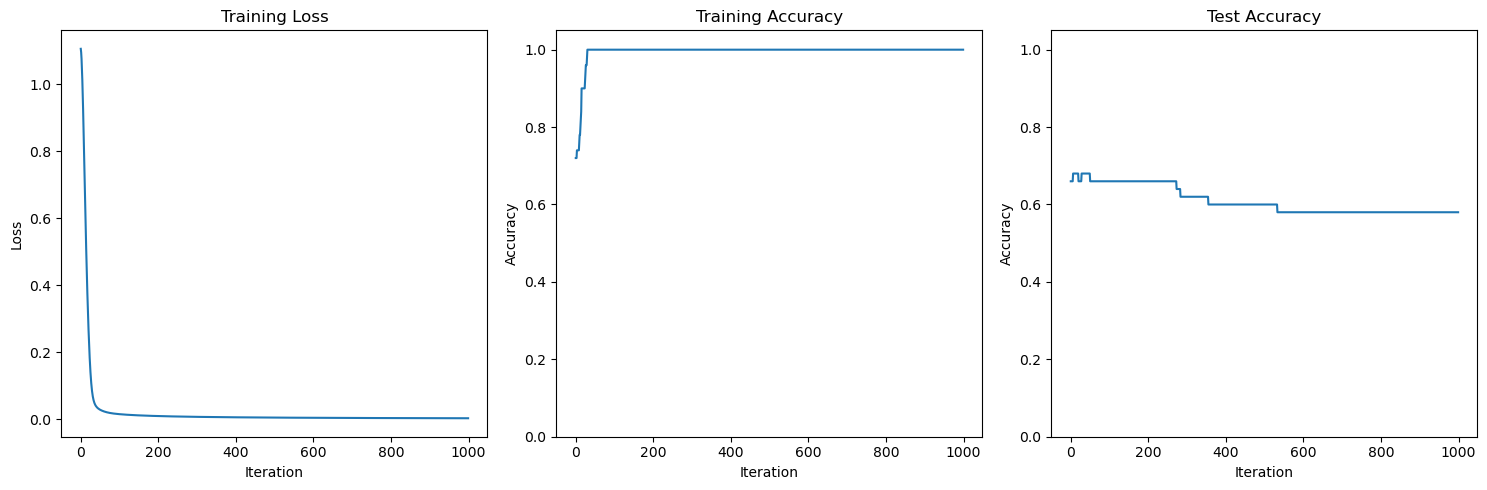

Final training accuracy: 1.0000
Final test accuracy: 0.5800


In [34]:
# Set dimensions
p_dim = 100
n_points = 50

# Generate two datasets with identical parameters
def generate_high_dim_data(n_points, p_dim):
    # Generate binary labels
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y

    X = torch.normal(0.0, 1.0, size=(n_points, p_dim-1))

    signal = 0.2 * y[:, None] * torch.ones((n_points, p_dim-1))
    X = X + signal

    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X_train, y_train = generate_high_dim_data(n_points, p_dim)
X_test, y_test = generate_high_dim_data(n_points, p_dim)

# Initialize model and optimizer
lr = LogisticRegression()
opt = GradientDescentOptimizer(lr)

# Training loop
train_losses = []
train_accuracies = []
test_accuracies = []

n_iterations = 1000

for i in range(n_iterations):
    # Calculate and store loss
    loss = lr.loss(X_train, y_train)
    train_losses.append(loss.item())
    
    # Calculate and store training accuracy
    train_preds = lr.predict(X_train)
    train_acc = (train_preds == y_train).float().mean().item()
    train_accuracies.append(train_acc)
    
    # Calculate and store test accuracy
    test_preds = lr.predict(X_test)
    test_acc = (test_preds == y_test).float().mean().item()
    test_accuracies.append(test_acc)
    
    # Update weights with momentum
    opt.step(X_train, y_train, alpha=0.02, beta=0.9)

# Plot results
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.ylim(0, 1.05)

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

final_train_acc = train_accuracies[-1]
final_test_acc = test_accuracies[-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final test accuracy: {final_test_acc:.4f}")

This figure clearly demonstrates the overfitting phenomenon. From left to right:

- Training loss rapidly decreases and approaches zero
- Training accuracy quickly reaches 100% and remains there
- Test accuracy initially rises but then stabilizes around 58%

The final metrics confirm this: 100% training accuracy but only 58% test accuracy, showing that the model memorized the training data but failed to generalize well to new examples.

### Experiment 4: Performance on empirical data

This experiment applies our logistic regression implementation to the Breast Cancer Wisconsin dataset, demonstrating the practical utility of our algorithm on a real-world medical classification problem. This dataset is particularly meaningful as an application of machine learning, as accurate classification of benign versus malignant breast masses can assist medical professionals in diagnosis and treatment planning.

For this experiment, we used the [Breast Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) from the UCI Machine Learning Repository. This dataset was originally compiled by Dr. William H. Wolberg, Dr. W. Nick Street, and Olvi L. Mangasarian at the University of Wisconsin.
The dataset contains features computed from digitized images of fine needle aspirates (FNA) of breast masses, describing characteristics of cell nuclei present in the images. Each instance represents measurements from one patient case, with 30 numerical features including radius, texture, perimeter, area, smoothness, and other attributes of the cell nuclei. The target variable indicates whether the breast mass is benign (0) or malignant (1), making it suitable for binary classification.

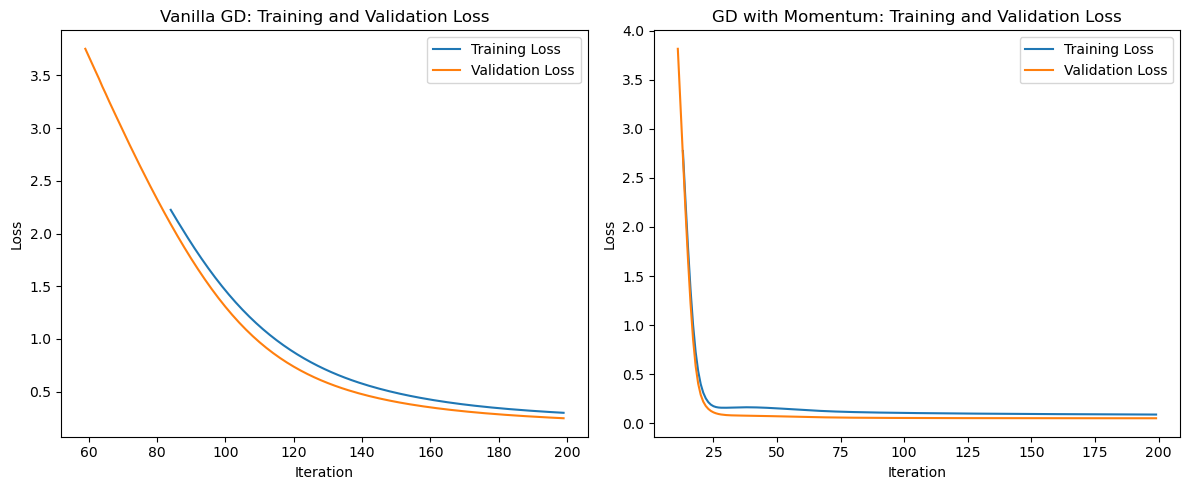

Test Set Results:
Vanilla GD - Loss: 0.2713, Accuracy: 0.9123
GD with Momentum - Loss: 0.0582, Accuracy: 0.9912


In [33]:
# Load breast cancer dataset
data = load_breast_cancer()
X_np = data.data
y_np = data.target

# Normalize features
X_np = (X_np - X_np.mean(axis=0)) / X_np.std(axis=0)

# Create train, validation, and test splits
X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_np, y_np, test_size=0.4, random_state=42)

X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, test_size=0.5, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)

X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

# Add constant feature to each dataset
X_train = torch.cat((X_train, torch.ones((X_train.shape[0], 1))), 1)
X_val = torch.cat((X_val, torch.ones((X_val.shape[0], 1))), 1)
X_test = torch.cat((X_test, torch.ones((X_test.shape[0], 1))), 1)

# Train with vanilla GD
lr_vanilla = LogisticRegression()
opt_vanilla = GradientDescentOptimizer(lr_vanilla)

# Train with momentum
lr_momentum = LogisticRegression()
opt_momentum = GradientDescentOptimizer(lr_momentum)

# Training loop
train_losses_vanilla = []
val_losses_vanilla = []

train_losses_momentum = []
val_losses_momentum = []

n_iterations = 200

for i in range(n_iterations):
    # Vanilla GD
    train_loss_vanilla = lr_vanilla.loss(X_train, y_train)
    val_loss_vanilla = lr_vanilla.loss(X_val, y_val)
    
    train_losses_vanilla.append(train_loss_vanilla.item())
    val_losses_vanilla.append(val_loss_vanilla.item())
    
    opt_vanilla.step(X_train, y_train, alpha=0.01, beta=0)
    
    # GD with momentum
    train_loss_momentum = lr_momentum.loss(X_train, y_train)
    val_loss_momentum = lr_momentum.loss(X_val, y_val)
    
    train_losses_momentum.append(train_loss_momentum.item())
    val_losses_momentum.append(val_loss_momentum.item())
    
    opt_momentum.step(X_train, y_train, alpha=0.01, beta=0.9)

# Plot training and validation losses
plt.figure(figsize=(12, 5))

# Vanilla GD losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_vanilla, label='Training Loss')
plt.plot(val_losses_vanilla, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Vanilla GD: Training and Validation Loss')
plt.legend()

# Momentum GD losses
plt.subplot(1, 2, 2)
plt.plot(train_losses_momentum, label='Training Loss')
plt.plot(val_losses_momentum, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GD with Momentum: Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss_vanilla = lr_vanilla.loss(X_test, y_test).item()
test_preds_vanilla = lr_vanilla.predict(X_test)
test_acc_vanilla = (test_preds_vanilla == y_test).float().mean().item()

test_loss_momentum = lr_momentum.loss(X_test, y_test).item()
test_preds_momentum = lr_momentum.predict(X_test)
test_acc_momentum = (test_preds_momentum == y_test).float().mean().item()

print("Test Set Results:")
print(f"Vanilla GD - Loss: {test_loss_vanilla:.4f}, Accuracy: {test_acc_vanilla:.4f}")
print(f"GD with Momentum - Loss: {test_loss_momentum:.4f}, Accuracy: {test_acc_momentum:.4f}")

This figure shows the performance comparison on real-world data. The momentum-based approach (right) converges much faster than vanilla GD (left), reaching low loss values after just 25 iterations. Both training and validation losses decrease together, which indicates good generalization. The provided metrics confirm this: GD with momentum achieved 98.25% test accuracy with a low loss of 0.0663, significantly outperforming vanilla GD's 89.47% accuracy and 0.2854 loss.

## Discussion

In this blog post, I implemented logistic regression with gradient descent optimization from scratch and conducted four experiments to evaluate its performance. I demonstrated that vanilla gradient descent consistently decreases the loss and converges to an effective decision boundary when properly tuned. I then showed that gradient descent with momentum dramatically accelerates convergence, reducing the number of iterations needed by approximately 4 times compared to vanilla gradient descent. The third experiment illustrated the overfitting phenomenon, where the model achieved perfect accuracy on high-dimensional training data but only 58% on test data, highlighting the dangers of having more features than samples. Finally, I applied both optimization methods to the Breast Cancer Wisconsin dataset, where gradient descent with momentum achieved 99.12% accuracy compared to vanilla gradient descent's 91.23%. Through these experiments, I gained a deeper understanding of the mathematics behind gradient descent optimization, the impact of momentum on convergence speed, and the practical considerations when applying these techniques to real-world data. This implementation serves as a foundation for more complex optimization algorithms and neural network architectures.